<a href="https://colab.research.google.com/github/Tanjul5/Speech-Emotion-Recognition/blob/main/speech_emotion_recognition_capstone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Speech Emotion Recognition(SER)**

###**Emotion classification using the RAVDESS dataset**

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) is licensed under CC BY-NA-SC 4.0. and can be downloaded free of charge at https://zenodo.org/record/1188976.

**Construction and Validation**

Construction and validation of the RAVDESS is described in our paper: Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

The RAVDESS contains 7356 files. Each file was rated 10 times on emotional validity, intensity, and genuineness. Ratings were provided by 247 individuals who were characteristic of untrained adult research participants from North America. A further set of 72 participants provided test-retest data. High levels of emotional validity, interrater reliability, and test-retest intrarater reliability were reported. Validation data is open-access, and can be downloaded along with our paper from PLOS ONE.

**Description**

The dataset contains the complete set of 7356 RAVDESS files (total size: 24.8 GB). Each of the 24 actors consists of three modality formats: Audio-only (16bit, 48kHz .wav), Audio-Video (720p H.264, AAC 48kHz, .mp4), and Video-only (no sound). Note, there are no song files for Actor_18.

**Data**

For this task, we are using 1440 samples from the RAVDESS dataset.

The samples comes from:


**Audio-files(speech only)**

**License information**

The RAVDESS is released under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License, CC BY-NA-SC 4.0

**File naming convention**

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics:

**Filename identifiers**

*   Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
*   Vocal channel (01 = speech, 02 = song).
*   Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
*   Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
*   Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
*   Repetition (01 = 1st repetition, 02 = 2nd repetition).
*   Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


Filename example: 02-01-06-01-02-01-12.mp4

*   Video-only (02)
*   Speech (01)
*   Fearful (06)
*   Normal intensity (01)
*   Statement “dogs” (02)
*   1st Repetition (01)
*   12th Actor (12)
*   Female, as the actor ID number is even.


## **Analysis**
We are using Google Colab, a Google Cloud environment for jupyter, so we need to import our files from Google Drive and then install LibROSA, a python package for music and audio analysis.

After the import, we will plot the signal of the first file.



###**Importing Libraries**

In [1]:
# IMPORT NECESSARY LIBRARIES
import librosa
import librosa.display
from tqdm import tqdm

import os, glob, sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline

import soundfile as sf
import IPython.display as ipd
from IPython.display import Audio

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

import keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Conv2D, MaxPool2D, Conv1D, MaxPool1D

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
#mounting the google drive to import the dataset

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
audio = "/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/RAVDESS/"

# DATA PREPROCESSING

In [4]:
# CREATE DIRECTORY OF AUDIO FILES 
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:5]

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05']

**We have converted audio speech files into List dtype.**

In [5]:
# CREATE FUNCTION TO EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
emotion = []
gender = []
actor = []
file_path = []
for i in actor_folders:
    filename = os.listdir(audio + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio + i + '/' + f)

In [6]:
# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
audio_df.columns = ['gender','emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
audio_df.head()

,gender,emotion,actor,path
0,male,neutral,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...
1,male,neutral,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...
2,male,calm,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...
3,male,calm,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...
4,male,calm,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...


# **Data visulization**

# **COUNTS OF EMOTION**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


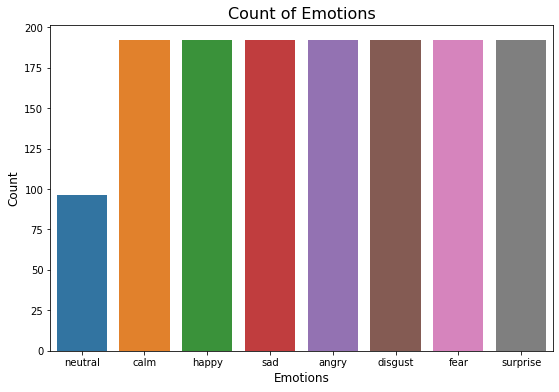

In [7]:
plt.figure(figsize=(9,6))
plt.title('Count of Emotions', size=16)
sns.countplot(audio_df.emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
# sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

***There are eight type of emotions are present in dataset as neutral, calm, happy, sad, angry, fear, disgust, surprise. Neutral emotion data is less in numbers as compared to other emotions.***

We can also plot waveplots and spectograms for audio signals

Waveplots - Waveplots let us know the loudness of the audio at a given time.

Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

### **Male Happy**

Text(0.5, 1.0, 'Waveplot - Male Happy')

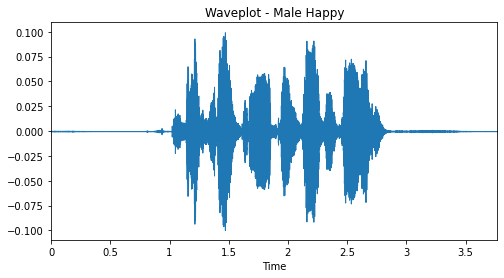

In [8]:
# DISPLAY WAVEPLOT
x, sr = librosa.load(f'/{audio}/Actor_03/03-01-03-01-01-01-03.wav')

# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Male Happy')

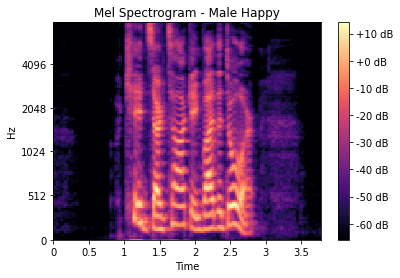

In [9]:
# CREATE LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
x = librosa.power_to_db(x)

librosa.display.specshow(x, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Happy')
plt.colorbar(format='%+2.0f dB');

### **Male Angry**

Text(0.5, 1.0, 'Waveplot - Male Angry')

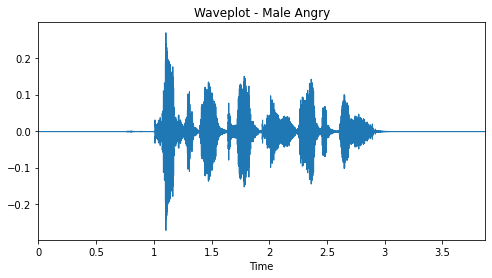

In [10]:
# LOAD FILE
x, sr = librosa.load(f'/{audio}/Actor_05/03-01-05-01-01-01-05.wav')
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Male Angry')

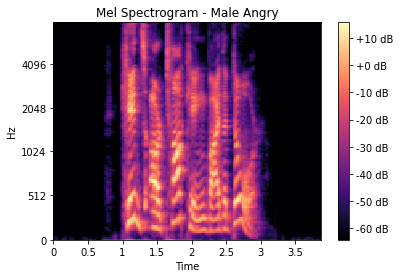

In [11]:
# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Angry');
plt.colorbar(format='%+2.0f dB');

#### **Female Fearful**

Text(0.5, 1.0, 'Waveplot - Female Fearful')

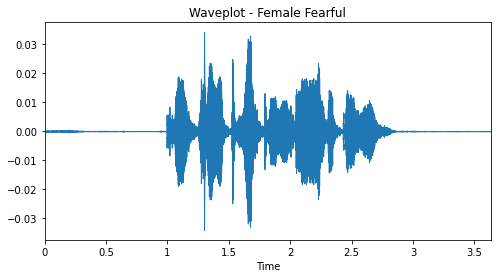

In [12]:
# LOAD FILE
x, sr = librosa.load(f'/{audio}/Actor_06/03-01-06-01-01-01-06.wav')
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Female Fearful')

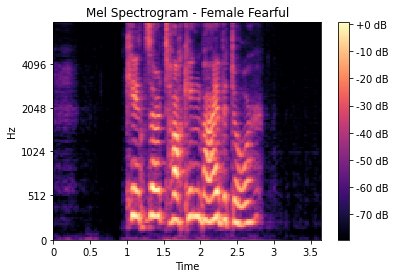

In [13]:
# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Fearful')
plt.colorbar(format='%+2.0f dB');

#### **Female Surprised**

Text(0.5, 1.0, 'Waveplot - FemaleSurprised')

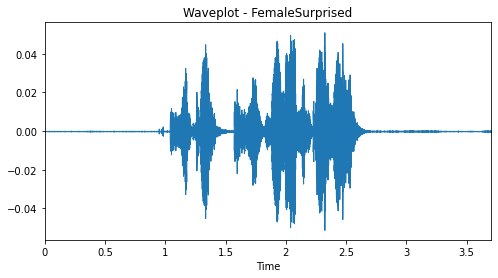

In [14]:
# LOAD FILE
x, sr = librosa.load(f'/{audio}/Actor_08/03-01-08-01-01-01-08.wav')
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - FemaleSurprised')

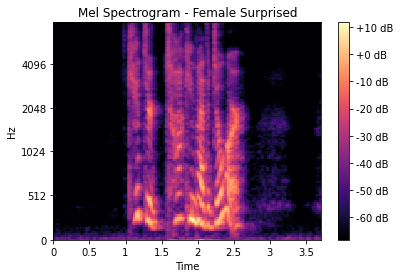

In [15]:
# DISPLAY LOG MEL SPECTROGRAM
x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000) 
y = librosa.power_to_db(x)

librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Surprised')
plt.colorbar(format='%+2.0f dB');

**So in above plots we have created a Waveplots and Mel Spectrograms for different emotions classifications.**

**So we have extracted the audio speech files path and created a DataFrame out of it.**

In [16]:
#shape of the dataframe
audio_df.shape

(1440, 4)

In [17]:
# EXPORT TO CSV
audio_df.to_csv('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/RAVDAS.csv')

In [18]:
# READ IN CSV FILE FROM EDA_PREPROCESSING
audio_df=pd.read_csv('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/RAVDAS.csv',usecols=['emotion','path','gender','actor'])
audio_df.head()

,gender,emotion,actor,path
0,male,neutral,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...
1,male,neutral,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...
2,male,calm,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...
3,male,calm,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...
4,male,calm,1,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...


In [19]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(audio_df, test_size=0.2, random_state=0,
                               stratify=audio_df[['emotion','gender','actor']])

In [20]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(audio_df, test_size=0.2, random_state=0,
                               stratify=audio_df[['emotion','gender','actor']])

In [21]:
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)

(1152, 1)


# Data Augmentation

Add Noise, Stretch, Speed and Pitch to Original Audio File

Text(0.5, 1.0, 'Waveplot - Male happy')

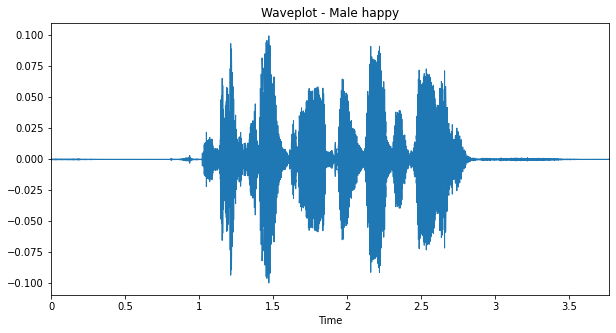

In [22]:
# MALE Happy ORIGINAL AUDIO FILE
fname = audio + 'Actor_03/03-01-03-01-01-01-03.wav'  
X, sr = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(X, sr=sr)
plt.title('Waveplot - Male happy')

# **NOISE**

In [23]:
# FUNCTION TO ADD WHITE NOISE
def noise(x):
    noise_amp = 0.05*np.random.uniform()*np.amax(x)   
    x = x.astype('float64') + noise_amp * np.random.normal(size=x.shape[0])
    return x

Text(0.5, 1.0, 'Waveplot - Noise Male Happy')

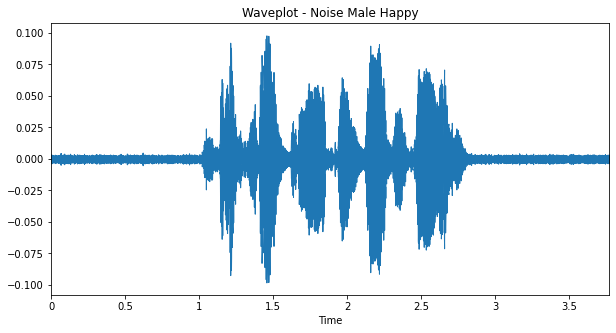

In [24]:
 #ADD NOISE TO MALE Happy ORIGINAL AUDIO FILE
x = noise(X)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Noise Male Happy')

**STRECH**

In [25]:
# FUNCTION TO STRETCH THE SOUND
def stretch(x, rate=0.8):
    data = librosa.effects.time_stretch(x, rate)
    return data

Text(0.5, 1.0, 'Waveplot - Stretch Male Happy')

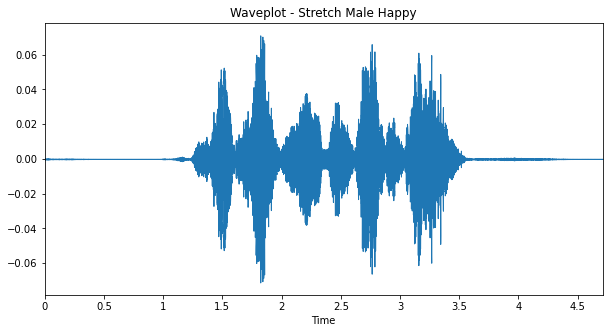

In [26]:
# ADD STRETCH TO MALE Happy ORIGINAL AUDIO FILE
x = stretch(X)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Stretch Male Happy')

# **Speed N Pitch**

In [27]:
# FUNCTION TO INCREASE SPEED AND PITCH 
def speedNpitch(x):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change 
    tmp = np.interp(np.arange(0,len(x),speed_fac),np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x *= 0
    x[0:minlen] = tmp[0:minlen]
    return x

Text(0.5, 1.0, 'Waveplot - Speed and Pitch Male Happy')

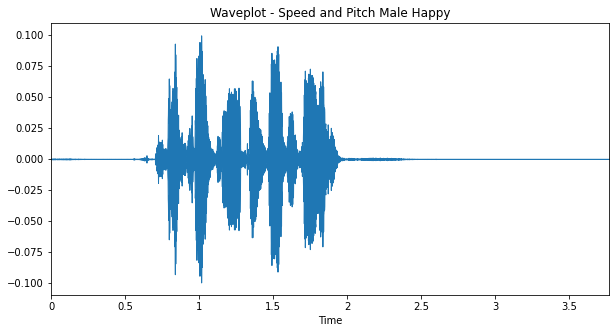

In [28]:
# ADD SPEED AND PITCH TO MALE Happy ORIGINAL AUDIO FILE
x = speedNpitch(X)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Speed and Pitch Male Happy')

The above shown all distints waveplots have been created after adding Noise, Stretch, Speed and Pitch to Original Audio File.

# **Apply Data Augmentation Methods to Train Set**

In [29]:
# FEATURE EXTRACTION ON RAW AUDIO FILES
df = pd.DataFrame(columns=['log_spec'])
counter=0

for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    df.loc[counter] = [log_spectrogram]   
    counter += 1
print(len(df))
df.head()

1152


,log_spec
0,"[-68.16176, -68.16176, -68.16176, -68.05568, -..."
1,"[-67.89777, -67.764366, -67.82783, -68.09808, ..."
2,"[-66.06582, -66.0507, -66.06643, -66.07191, -6..."
3,"[-63.501076, -63.501076, -63.420914, -62.75046..."
4,"[-70.07283, -69.86238, -69.91055, -69.819855, ..."


In [30]:
# ADD NOISE AND USE FEATURE EXTRACTION
df_noise = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # noise 
    aug = noise(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_noise.loc[counter] = [aug]
    counter +=1
print(len(df_noise))
df_noise.head()

1152


,feature
0,"[-68.16176, -68.16176, -68.16176, -68.05568, -..."
1,"[-67.89777, -67.764366, -67.82783, -68.09808, ..."
2,"[-66.06582, -66.0507, -66.06643, -66.07191, -6..."
3,"[-63.501076, -63.501076, -63.420914, -62.75046..."
4,"[-70.07283, -69.86238, -69.91055, -69.819855, ..."


In [31]:
# ADD SPEED AND PITCH THEN USE FEATURE EXTRACTION
df_speedpitch = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # speed pitch
    aug = speedNpitch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_speedpitch.loc[counter] = [aug] 
    counter +=1
print(len(df_speedpitch))
df_speedpitch.head()

1152


,feature
0,"[-69.64107, -69.64107, -69.539925, -69.54547, ..."
1,"[-68.61925, -68.634285, -68.70743, -68.515076,..."
2,"[-67.13537, -67.149925, -67.16369, -67.077934,..."
3,"[-63.3534, -63.351414, -61.692738, -56.52126, ..."
4,"[-70.5634, -70.47201, -70.378265, -70.299995, ..."


In [32]:
# ADD STRETCH AND USE FEATURE EXTRACTION ON AUDIO FILES
df_stretch=pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # stretch
    aug= stretch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_stretch.loc[counter] = [aug] 
    counter +=1
print(len(df_stretch))
df_stretch.head()

1152


,feature
0,"[-68.16176, -68.16176, -68.16176, -68.05568, -..."
1,"[-67.89777, -67.764366, -67.82783, -68.09808, ..."
2,"[-66.06582, -66.0507, -66.06643, -66.07191, -6..."
3,"[-63.501076, -63.501076, -63.420914, -62.75046..."
4,"[-70.07283, -69.86238, -69.91055, -69.819855, ..."


# Combine Tables For Modeling

In [33]:
# EXTRACT EMOTION LABELS FROM TRAIN
labels = train.emotion
labels.reset_index(drop=True, inplace=True)
labels

0          angry
1       surprise
2       surprise
3       surprise
4       surprise
          ...   
1147       angry
1148         sad
1149         sad
1150        calm
1151        fear
Name: emotion, Length: 1152, dtype: object

In [34]:
# ADD CORRESPONDING EMOTION LABELS TO DF['LOG_SPEC']
mfcc_df = pd.DataFrame(df['log_spec'].values.tolist())
mfcc = pd.concat([mfcc_df,labels], axis=1,ignore_index=True)
mfcc = mfcc.rename(index=str, columns={259: "emotion"})

In [35]:
# ADD CORRESPONDING EMOTION LABELS TO DF_NOISE['FEATURE']
noise_df = pd.DataFrame(df_noise['feature'].values.tolist())
noise = pd.concat([noise_df,labels], axis=1)
noise = noise.rename(index=str, columns={259: "label"})

In [36]:
# ADD CORRESPONDING EMOTION LABELS TO DF_SPEEDPITCH['FEATURE']
speedpitch_df = pd.DataFrame(df_speedpitch['feature'].values.tolist())
speedpitch = pd.concat([speedpitch_df,labels], axis=1)
speedpitch = speedpitch.rename(index=str, columns={259: "label"})

In [37]:
# ADD CORRESPONDING EMOTION LABELS TO DF_STRETCH['FEATURE']
stretch_df = pd.DataFrame(df_stretch['feature'].values.tolist())
stretch = pd.concat([stretch_df,labels], axis=1)
stretch = stretch.rename(index=str, columns={259: "label"})

In [38]:
# JOIN FOUR DATA FRAMES FOR MODELING
combined_df = pd.concat([mfcc, noise, speedpitch,stretch], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
4603,-45.475925,-45.482555,-45.482555,-45.482555,-45.482555,-45.478024,-45.447929,-45.268700,-45.243233,-45.291142,...,-30.661184,-32.678814,-34.794762,-36.341885,-37.813969,-38.328606,-39.064583,-40.051395,-40.789944,angry
4604,-75.133110,-75.315697,-75.560944,-75.835281,-76.157875,-76.135368,-74.641289,-71.589348,-72.556984,-75.086311,...,-75.591003,-74.922226,-74.993004,-75.281715,-75.898544,-75.818367,-75.410301,-75.072365,-75.467789,sad
4605,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,...,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,-75.913658,sad
4606,-79.743843,-78.552917,-78.477829,-78.209030,-78.184258,-79.843422,-79.147881,-79.930328,-80.102211,-79.086334,...,-80.547226,-80.879211,-79.456299,-80.065697,-79.707115,-79.203743,-79.565636,-79.188126,-78.859329,calm
4607,-49.329632,-49.102230,-49.301510,-49.695385,-49.817989,-49.963058,-50.396370,-50.743469,-50.763409,-51.183369,...,-48.659504,-48.363129,-47.912518,-46.909565,-47.177670,-48.008980,-49.500362,-50.187866,-51.033173,fear


The new Dataframe after implementing data augmentation technique and extracting distinct features by using Mel spectrogram.

In [39]:
mfcc.shape,noise.shape,speedpitch.shape,stretch.shape

((1152, 260), (1152, 260), (1152, 260), (1152, 260))

In [40]:
X_train = combined_df.iloc[:, :-1]
y_train = combined_df.iloc[:, -1:]

# Feature Extraction for Test Set

In [41]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
df = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(test.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    
    df.loc[counter] = [log_spectrogram]
    counter=counter+1   

print(len(df))
df.head()

288


,mel_spectrogram
0,"[-62.509396, -62.509396, -62.509396, -62.50939..."
1,"[-60.20934, -59.81177, -59.22416, -57.768997, ..."
2,"[-63.505745, -63.505745, -63.505745, -63.50574..."
3,"[-56.86472, -56.86472, -56.86472, -56.86472, -..."
4,"[-64.129486, -64.129486, -64.129486, -64.12948..."


In [42]:
test.reset_index(drop=True,inplace=True)

In [43]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([test,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)
df_combined.head()

,gender,emotion,actor,path,0,1,2,3,4,5,...,249,250,251,252,253,254,255,256,257,258
0,female,fear,4,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...,-62.509396,-62.509396,-62.509396,-62.509396,-62.509396,-62.509396,...,-62.034119,-61.989449,-62.067112,-61.848236,-61.963779,-62.174000,-62.197716,0.000000,0.000000,0.000000
1,male,calm,21,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...,-60.209339,-59.811771,-59.224159,-57.768997,-57.250759,-58.409416,...,-69.339752,-69.336502,-69.349205,-69.751045,-70.172417,-70.515358,-70.410995,-70.297112,-70.876534,-71.681648
2,female,happy,16,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...,-63.505745,-63.505745,-63.505745,-63.505745,-63.505745,-63.505745,...,-63.505745,-63.505745,-63.505745,-63.480534,-63.481899,-63.371727,-63.451057,-63.453751,-63.173615,-63.183102
3,female,angry,12,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...,-56.864719,-56.864719,-56.864719,-56.864719,-56.864719,-56.864719,...,-56.523342,-56.526863,-56.326191,-56.233452,-56.266747,-56.381920,-56.618176,-56.520161,-56.380272,-56.208210
4,male,fear,23,/content/drive/MyDrive/SPEECH EMOTION RECOGBIT...,-64.129486,-64.129486,-64.129486,-64.129486,-64.129486,-64.129486,...,-64.129486,-64.129486,-64.129486,-64.129486,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [44]:
# DROP PATH COLUMN FOR MODELING
df_combined.drop(columns='path',inplace=True)

In [45]:
df_combined.head()

,gender,emotion,actor,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,female,fear,4,-62.509396,-62.509396,-62.509396,-62.509396,-62.509396,-62.509396,-62.509396,...,-62.034119,-61.989449,-62.067112,-61.848236,-61.963779,-62.174000,-62.197716,0.000000,0.000000,0.000000
1,male,calm,21,-60.209339,-59.811771,-59.224159,-57.768997,-57.250759,-58.409416,-58.399258,...,-69.339752,-69.336502,-69.349205,-69.751045,-70.172417,-70.515358,-70.410995,-70.297112,-70.876534,-71.681648
2,female,happy,16,-63.505745,-63.505745,-63.505745,-63.505745,-63.505745,-63.505745,-63.505745,...,-63.505745,-63.505745,-63.505745,-63.480534,-63.481899,-63.371727,-63.451057,-63.453751,-63.173615,-63.183102
3,female,angry,12,-56.864719,-56.864719,-56.864719,-56.864719,-56.864719,-56.864719,-56.864719,...,-56.523342,-56.526863,-56.326191,-56.233452,-56.266747,-56.381920,-56.618176,-56.520161,-56.380272,-56.208210
4,male,fear,23,-64.129486,-64.129486,-64.129486,-64.129486,-64.129486,-64.129486,-64.129486,...,-64.129486,-64.129486,-64.129486,-64.129486,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [46]:
# SEPARATE DF_COMBINED INTO X_TEST AND Y_TEST
X_test = df_combined.iloc[:, 3:]
y_test = df_combined.iloc[:,:2].drop(columns=['gender'])

# DATA PREPARATION AND FEATURE ENGINEERING

In [47]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [48]:
# TURN INTO ARRAYS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [49]:
# ONE HOT ENCODE EMOTION LABELS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [50]:
# RESHAPE TO ADD 3D TENSOR FOR 1D CNN INPUT
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_train.shape,X_test.shape

((4608, 259, 1), (288, 259, 1))

# MODELLING

# **1. CNN**

In [51]:
# BUILD 1D CNN LAYERS
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# BUILD 1D CNN LAYERS
model = Sequential()
model.add(Conv1D(64, kernel_size=(20), activation='relu', input_shape=(X_train.shape[1],1)))

model.add(Conv1D(128, kernel_size=(20),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=(20),activation='relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
model.summary()
opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 240, 64)           1344      
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 128)          163968    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 27, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 27, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 8, 128)            327808    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 128)           0         
 1D)                                                    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


fitting the model

In [52]:
checkpoint = ModelCheckpoint('face_detector.h15', monitor= 'val_loss', mode= 'min', save_best_only = True, verbose= 1)

# FIT MODEL
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train,batch_size=8, epochs=80, validation_data=(X_test, y_test),callbacks=checkpoint)

Epoch 1/80
575/576 [============================>.] - ETA: 0s - loss: 2.3037 - accuracy: 0.2759
Epoch 1: val_loss improved from inf to 1.91230, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15/assets
576/576 [==============================] - 18s 13ms/step - loss: 2.3028 - accuracy: 0.2758 - val_loss: 1.9123 - val_accuracy: 0.3472
Epoch 2/80
575/576 [============================>.] - ETA: 0s - loss: 1.8800 - accuracy: 0.3391
Epoch 2: val_loss improved from 1.91230 to 1.69208, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15/assets
576/576 [==============================] - 7s 12ms/step - loss: 1.8801 - accuracy: 0.3392 - val_loss: 1.6921 - val_accuracy: 0.3715
Epoch 3/80
572/576 [============================>.] - ETA: 0s - loss: 1.7246 - accuracy: 0.3778
Epoch 3: val_loss improved from 1.69208 to 1.61638, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15/assets
576/576 [====

# Plot loss and accuracy over epoches

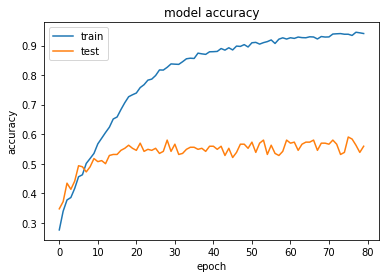

In [53]:
# PRINT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model_Accuracy.png')
plt.show()

training accuracy is increasing over the epoches but test accuracy is slightly constant.

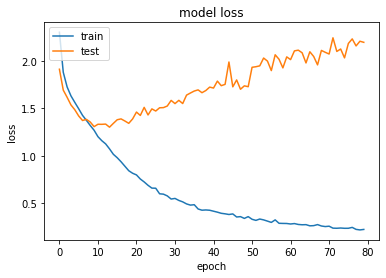

In [54]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model_Loss.png')
plt.show()

Loss is increasing in test data but decreasing in train data.

In [55]:
# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = actual.join(predictions)
finaldf[140:150]

,Actual Values,Predicted Values
140,sad,sad
141,surprise,fear
142,neutral,calm
143,sad,sad
144,fear,angry
145,sad,sad
146,disgust,disgust
147,angry,angry
148,surprise,fear
149,angry,sad


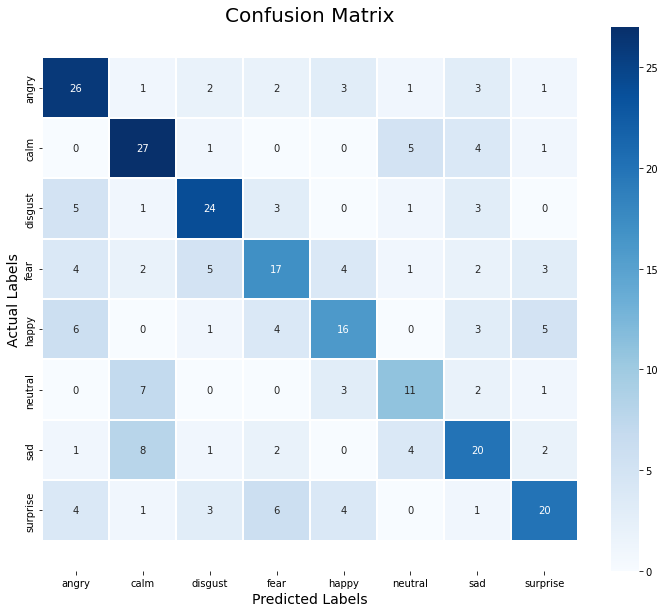

In [56]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Augmented_Model_Confusion_Matrix.png')
plt.show()

In [57]:
from sklearn.metrics import classification_report
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.57      0.67      0.61        39
        calm       0.57      0.71      0.64        38
     disgust       0.65      0.65      0.65        37
        fear       0.50      0.45      0.47        38
       happy       0.53      0.46      0.49        35
     neutral       0.48      0.46      0.47        24
         sad       0.53      0.53      0.53        38
    surprise       0.61      0.51      0.56        39

    accuracy                           0.56       288
   macro avg       0.55      0.55      0.55       288
weighted avg       0.56      0.56      0.56       288



CNN gives us only 59% accuracy which is very less.

# 2. VGG 16

DATA PREPARATION FPR VGG 16 MODEL

In [58]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(audio_df, test_size=0.2, random_state=0,
                               stratify=audio_df[['emotion','gender','actor']])

# Making Train_logmel folder

Converting training audio files to spectogram images and storing it in drive

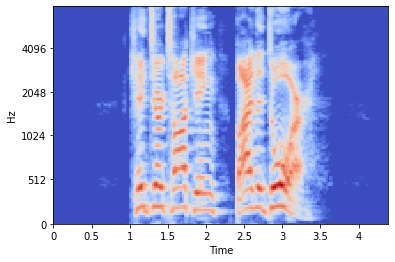

In [59]:
counter=0
for index,path in enumerate(train.path):
  if train.iloc[counter,1]=='angry':
    x, sr = librosa.load(path)
    x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
    y = librosa.power_to_db(x)
    librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
    plt.savefig(f'/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/train data/angry/{counter}.png')
  counter=counter+1

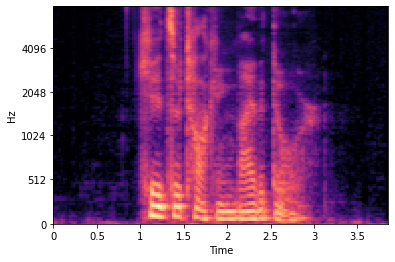

In [60]:
counter=0
for index,path in enumerate(train.path):
  if train.iloc[counter,1]=='calm':
    x, sr = librosa.load(path)
    x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
    y = librosa.power_to_db(x)
    librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
    plt.savefig(f'/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/train data/calm/{counter}.png')
  counter=counter+1

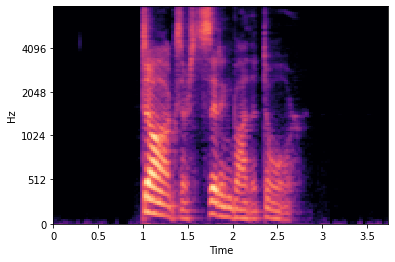

In [61]:
counter=0
for index,path in enumerate(train.path):
  if train.iloc[counter,1]=='disgust':
    x, sr = librosa.load(path)
    x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
    y = librosa.power_to_db(x)
    librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
    plt.savefig(f'/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/train data/disgust/{counter}.png')
  counter=counter+1

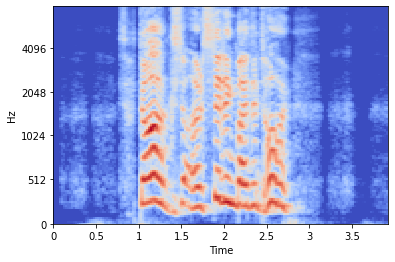

In [62]:
counter=0
for index,path in enumerate(train.path):
  if train.iloc[counter,1]=='fear':
    x, sr = librosa.load(path)
    x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
    y = librosa.power_to_db(x)
    librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
    plt.savefig(f'/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/train data/fearful/{counter}.png')
  counter=counter+1

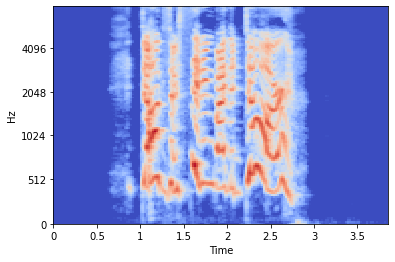

In [63]:
counter=0
for index,path in enumerate(train.path):
  if train.iloc[counter,1]=='happy':
    x, sr = librosa.load(path)
    x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
    y = librosa.power_to_db(x)
    librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
    plt.savefig(f'/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/train data/happy/{counter}.png')
  counter=counter+1

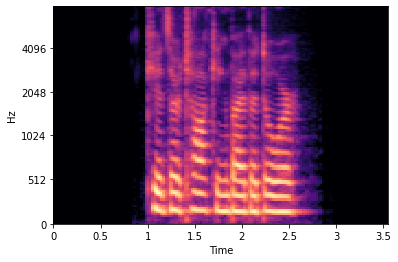

In [64]:
counter=0
for index,path in enumerate(train.path):
  if train.iloc[counter,1]=='neutral':
    x, sr = librosa.load(path)
    x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
    y = librosa.power_to_db(x)
    librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
    plt.savefig(f'/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/train data/neutral/{counter}.png')
  counter=counter+1

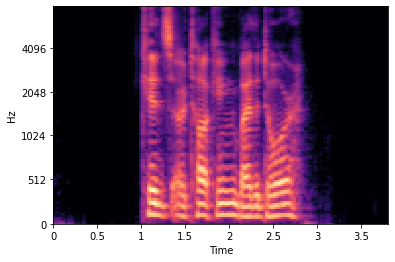

In [65]:
counter=0
for index,path in enumerate(train.path):
  if train.iloc[counter,1]=='sad':
    x, sr = librosa.load(path)
    x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
    y = librosa.power_to_db(x)
    librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
    plt.savefig(f'/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/train data/sad/{counter}.png')
  counter=counter+1

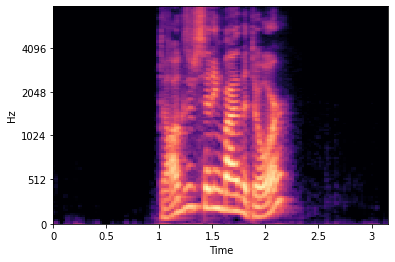

In [66]:
counter=0
for index,path in enumerate(train.path):
  if train.iloc[counter,1]=='surprise':
    x, sr = librosa.load(path)
    x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
    y = librosa.power_to_db(x)
    librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
    plt.savefig(f'/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/train data/surprised/{counter}.png')
  counter=counter+1

# Making Test_logmel folder

Converting testing audio files to spectogram images and storing it in drive

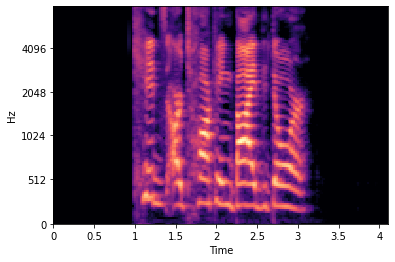

In [67]:
counter=0
for index,path in enumerate(test.path):
  if test.iloc[counter,1]=='angry':
    x, sr = librosa.load(path)
    x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
    y = librosa.power_to_db(x)
    librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
    plt.savefig(f'/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/test data/angry/{counter}.png')
  counter=counter+1

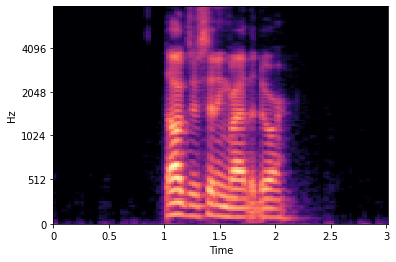

In [68]:
counter=0
for index,path in enumerate(test.path):
  if test.iloc[counter,1]=='calm':
    x, sr = librosa.load(path)
    x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
    y = librosa.power_to_db(x)
    librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
    plt.savefig(f'/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/test data/calm/{counter}.png')
  counter=counter+1

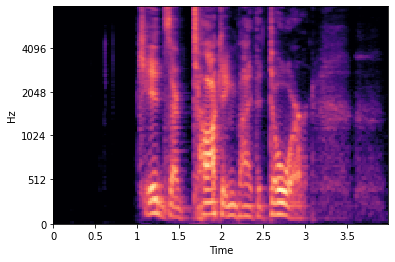

In [69]:
counter=0
for index,path in enumerate(test.path):
  if test.iloc[counter,1]=='disgust':
    x, sr = librosa.load(path)
    x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
    y = librosa.power_to_db(x)
    librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
    plt.savefig(f'/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/test data/disgust/{counter}.png')
  counter=counter+1

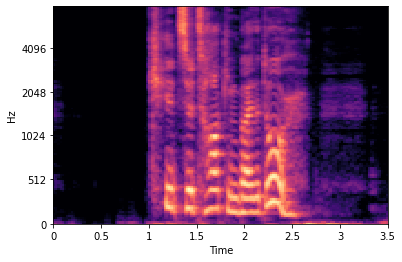

In [70]:
counter=0
for index,path in enumerate(test.path):
  if test.iloc[counter,1]=='fear':
    x, sr = librosa.load(path)
    x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
    y = librosa.power_to_db(x)
    librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
    plt.savefig(f'/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/test data/fearful/{counter}.png')
  counter=counter+1

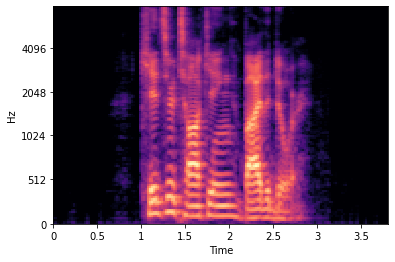

In [71]:
counter=0
for index,path in enumerate(test.path):
  if test.iloc[counter,1]=='happy':
    x, sr = librosa.load(path)
    x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
    y = librosa.power_to_db(x)
    librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
    plt.savefig(f'/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/test data/happy/{counter}.png')
  counter=counter+1

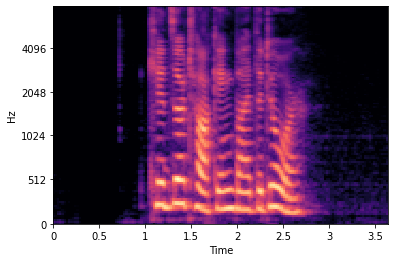

In [72]:
counter=0
for index,path in enumerate(test.path):
  if test.iloc[counter,1]=='neutral':
    x, sr = librosa.load(path)
    x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
    y = librosa.power_to_db(x)
    librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
    plt.savefig(f'/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/test data/neutral/{counter}.png')
  counter=counter+1

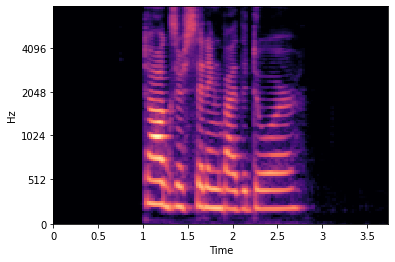

In [73]:
counter=0
for index,path in enumerate(test.path):
  if test.iloc[counter,1]=='sad':
    x, sr = librosa.load(path)
    x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
    y = librosa.power_to_db(x)
    librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
    plt.savefig(f'/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/test data/sad/{counter}.png')
  counter=counter+1

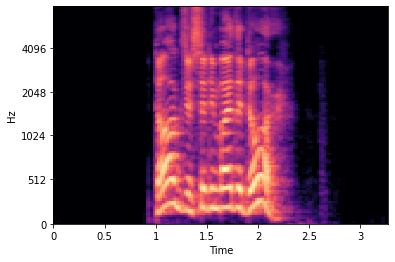

In [74]:
counter=0
for index,path in enumerate(test.path):
  if test.iloc[counter,1]=='surprise':
    x, sr = librosa.load(path)
    x = librosa.feature.melspectrogram(y=x, sr=sr,n_mels=128,fmax=8000)
    y = librosa.power_to_db(x)
    librosa.display.specshow(y, y_axis='mel', fmax=8000, x_axis='time')
    plt.savefig(f'/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/test data/surprised/{counter}.png')
  counter=counter+1

**So here we have converted all the audio files into Mel Spectrogram**

**Reading training file spectogram images**

In [75]:
import glob
angry = glob.glob('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/train data/angry/*.*')
calm = glob.glob('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/train data/calm/*.*')
disgust = glob.glob('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/train data/disgust/*.*')
fearful = glob.glob('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/train data/fearful/*.*')
happy = glob.glob('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/train data/happy/*.*')
neutral = glob.glob('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/train data/neutral/*.*')
sad = glob.glob('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/train data/sad/*.*')
surprised = glob.glob('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/train data/surprised/*.*')

In [76]:
train_data = []
train_labels = []

for i in angry:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Angry')
for i in calm:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Calm')
for i in disgust:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Disgust')
for i in fearful:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Fearful')
for i in happy:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Happy')
for i in neutral:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Neutral')
for i in sad:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Sad')
for i in surprised:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    train_data.append(image)
    train_labels.append('Surprised')

train_data = np.array(train_data)
train_labels = np.array(train_labels)

In [77]:
X_train=train_data
y_train=train_labels

Reading testing file spectogram images

In [78]:
import glob
angry = glob.glob('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/test data/angry/*.*')
calm = glob.glob('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/test data/calm/*.*')
disgust = glob.glob('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/test data/disgust/*.*')
fearful = glob.glob('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/test data/fearful/*.*')
happy = glob.glob('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/test data/happy/*.*')
neutral = glob.glob('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/test data/neutral/*.*')
sad = glob.glob('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/test data/sad/*.*')
surprised = glob.glob('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/test data/surprised/*.*')

In [79]:
test_data = []
test_labels = []

for i in angry:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Angry')
for i in calm:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Calm')
for i in disgust:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Disgust')
for i in fearful:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Fearful')
for i in happy:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Happy')
for i in neutral:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Neutral')
for i in sad:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Sad')
for i in surprised:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    test_data.append(image)
    test_labels.append('Surprised')

test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [80]:
X_test=test_data
y_test=test_labels

Some sample images

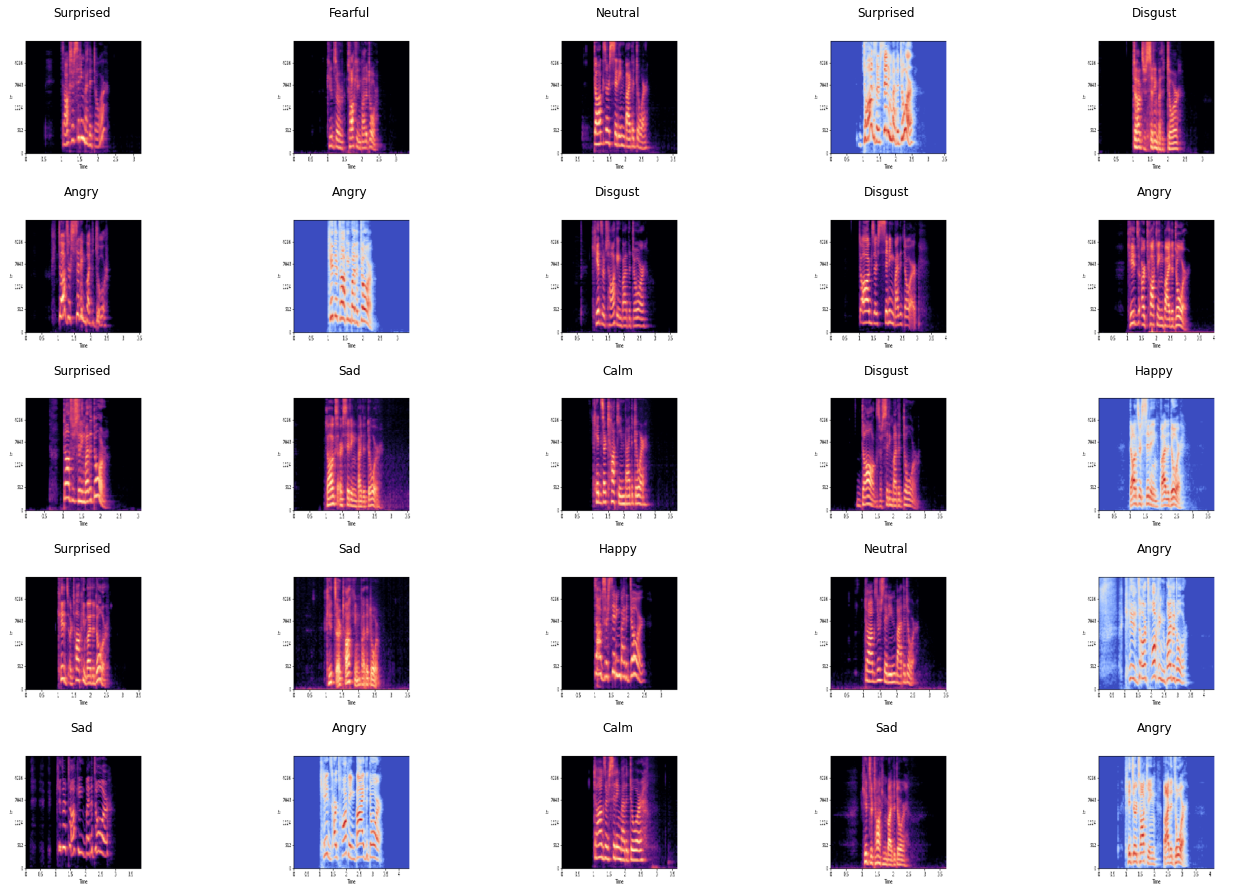

In [82]:
from random import randint
def get_classlabel(class_code):
    labels = {'Angry':'Angry', 'Calm':'Calm', 'Disgust':'Disgust', 'Fearful':'Fearful', 'Happy':'Happy', 'Neutral':'Neutral','Sad':'Sad','Surprised':'Surprised'}
    
    return labels[class_code]

f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0+1,len(train_data))
        ax[i,j].imshow(train_data[rnd_number])
        ax[i,j].set_title(get_classlabel(train_labels[rnd_number]))
        ax[i,j].axis('off')

In [83]:
# Check shapes of training and testing sets
print('X_train has a shape of {}, y_train has a shape of {}'.format(X_train.shape,y_train.shape))
print('X_test has a shape of {}, y_test has a shape of {}'.format(X_test.shape,y_test.shape))

X_train has a shape of (1152, 224, 224, 3), y_train has a shape of (1152,)
X_test has a shape of (288, 224, 224, 3), y_test has a shape of (288,)


In [84]:
# Finally, we normalize pixels in X_train and X_test to the range [0,1] for faster convergence
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [85]:
from keras.utils import np_utils
lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# **VGG16 Fine-Tuning**

In [87]:
from keras.applications.vgg16 import VGG16
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

58900480/58889256 [==============================] - 2s 0us/step


In [88]:
for layer in vgg_model.layers[:15]:
    layer.trainable = False

In [89]:
# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [91]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(8, activation='softmax')(x) # Softmax for multiclass

from tensorflow.keras import Model
transfer_model = Model(inputs=vgg_model.input, outputs=x)

In [94]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', 
                              patience = 2, 
                              verbose=1,
                              factor=0.3, 
                              min_lr=0.000001)

checkpoint = ModelCheckpoint('finetune.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

In [100]:
from tensorflow.keras import layers, models, Model, optimizers
learning_rate= 5e-5
transfer_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [101]:
# Here we use testing set as validation set
history = transfer_model.fit(X_train, y_train, batch_size = 1, epochs=14, validation_data=(X_test,y_test), callbacks=[lr_reduce,checkpoint])

Epoch 1/14
1151/1152 [============================>.] - ETA: 0s - loss: 1.9334 - accuracy: 0.2546
Epoch 1: val_accuracy improved from -inf to 0.41667, saving model to finetune.h15
INFO:tensorflow:Assets written to: finetune.h15/assets
1152/1152 [==============================] - 67s 57ms/step - loss: 1.9335 - accuracy: 0.2543 - val_loss: 1.5687 - val_accuracy: 0.4167 - lr: 5.0000e-05
Epoch 2/14
1152/1152 [==============================] - ETA: 0s - loss: 1.5199 - accuracy: 0.4332
Epoch 2: val_accuracy improved from 0.41667 to 0.54514, saving model to finetune.h15
INFO:tensorflow:Assets written to: finetune.h15/assets
1152/1152 [==============================] - 65s 57ms/step - loss: 1.5199 - accuracy: 0.4332 - val_loss: 1.1988 - val_accuracy: 0.5451 - lr: 5.0000e-05
Epoch 3/14
1152/1152 [==============================] - ETA: 0s - loss: 1.2693 - accuracy: 0.5382
Epoch 3: val_accuracy improved from 0.54514 to 0.55903, saving model to finetune.h15
INFO:tensorflow:Assets written to: finet

**Model accuracy graph**

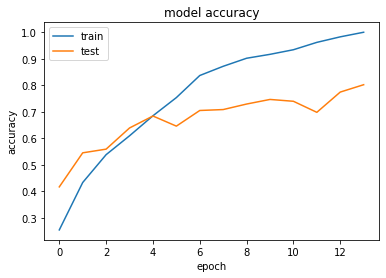

In [102]:
# PRINT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Augmented_Model_Accuracy.png')
plt.show()

**Model loss graph**

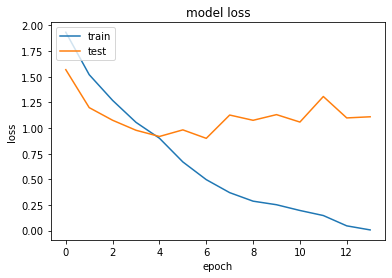

In [103]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Augmented_Model_Loss.png')
plt.show()

In [104]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Confusion Matrix**

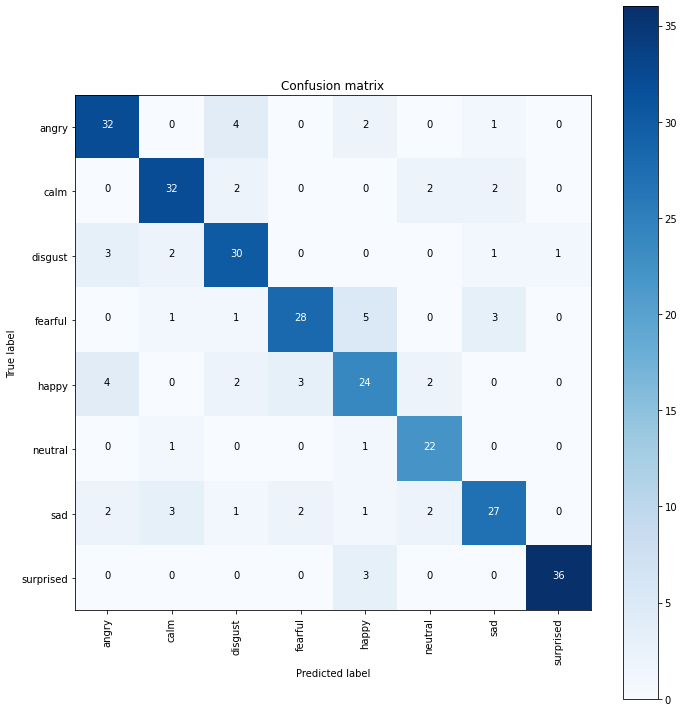

In [106]:
import itertools
y_pred = transfer_model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_test,axis=1)
dict_characters = {0: 'angry', 1: 'calm', 2: 'disgust', 3: 'fearful', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprised'}
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()

In [107]:
print(classification_report(Y_true, Y_pred_classes, target_names = ['angry','calm','disgust','fearful','happy','neutral','sad','surprised']))

              precision    recall  f1-score   support

       angry       0.78      0.82      0.80        39
        calm       0.82      0.84      0.83        38
     disgust       0.75      0.81      0.78        37
     fearful       0.85      0.74      0.79        38
       happy       0.67      0.69      0.68        35
     neutral       0.79      0.92      0.85        24
         sad       0.79      0.71      0.75        38
   surprised       0.97      0.92      0.95        39

    accuracy                           0.80       288
   macro avg       0.80      0.81      0.80       288
weighted avg       0.81      0.80      0.80       288



# **VGG19 Fine Tuning**

In [108]:
from tensorflow.keras.applications import vgg19
img_height, img_width = 224,224
conv_base = vgg19.VGG19(weights='imagenet', pooling='avg', include_top=False, input_shape = (img_width, img_height, 3))

80150528/80134624 [==============================] - 1s 0us/step


In [109]:
for layer in conv_base.layers[:12]:
    layer.trainable = False

In [110]:
# Make sure you have frozen the correct layers
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
22 global_average_pooling2d True


In [111]:
model=models.Sequential()
model.add(conv_base)
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.01))
model.add(Dense(8,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 20,157,768
Trainable params: 17,832,200
Non-trainable params: 2,325,568
_________________________________________________________________


In [112]:
batch_size=16
learning_rate = 5e-5
epochs = 50
checkpoint = ModelCheckpoint("vgg_19_classifier16.h5", monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [113]:
history = model.fit(X_train, y_train,batch_size=batch_size,
                              epochs=epochs,
                              shuffle=True, 
                              validation_data=(X_test,y_test),
                              callbacks=[checkpoint]
                              )

Epoch 1/50
72/72 [==============================] - ETA: 0s - loss: 1.8922 - acc: 0.2691
Epoch 1: val_acc improved from -inf to 0.36111, saving model to vgg_19_classifier16.h5
72/72 [==============================] - 28s 341ms/step - loss: 1.8922 - acc: 0.2691 - val_loss: 1.5637 - val_acc: 0.3611
Epoch 2/50
72/72 [==============================] - ETA: 0s - loss: 1.4550 - acc: 0.4627
Epoch 2: val_acc improved from 0.36111 to 0.57639, saving model to vgg_19_classifier16.h5
72/72 [==============================] - 24s 337ms/step - loss: 1.4550 - acc: 0.4627 - val_loss: 1.1420 - val_acc: 0.5764
Epoch 3/50
72/72 [==============================] - ETA: 0s - loss: 1.2040 - acc: 0.5486
Epoch 3: val_acc did not improve from 0.57639
72/72 [==============================] - 26s 357ms/step - loss: 1.2040 - acc: 0.5486 - val_loss: 1.3388 - val_acc: 0.5243
Epoch 4/50
72/72 [==============================] - ETA: 0s - loss: 1.0590 - acc: 0.6128
Epoch 4: val_acc improved from 0.57639 to 0.62500, savi

# **Model accuracy graph**

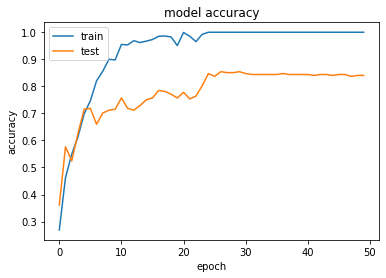

In [114]:
# PRINT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Augmented_Model_Accuracy.png')
plt.show()

# **Model loss graph**

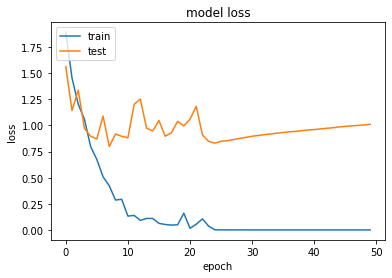

In [115]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Augmented_Model_Loss.png')
plt.show()

**Confusion Matrix**

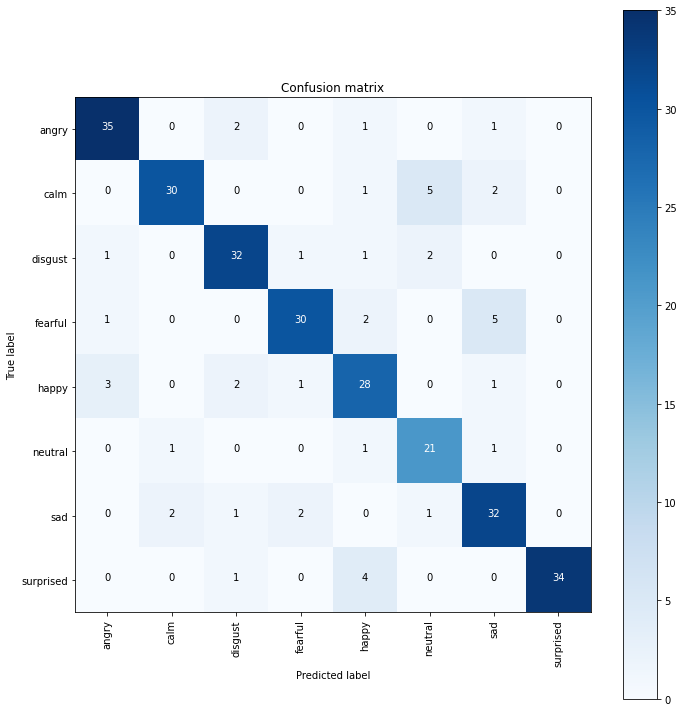

In [116]:
y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_test,axis=1)
dict_characters = {0: 'angry', 1: 'calm', 2: 'disgust', 3: 'fearful', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprised'}
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()

In [117]:
print(classification_report(Y_true, Y_pred_classes, target_names = ['angry','calm','disgust','fearful','happy','neutral','sad','surprised']))

              precision    recall  f1-score   support

       angry       0.88      0.90      0.89        39
        calm       0.91      0.79      0.85        38
     disgust       0.84      0.86      0.85        37
     fearful       0.88      0.79      0.83        38
       happy       0.74      0.80      0.77        35
     neutral       0.72      0.88      0.79        24
         sad       0.76      0.84      0.80        38
   surprised       1.00      0.87      0.93        39

    accuracy                           0.84       288
   macro avg       0.84      0.84      0.84       288
weighted avg       0.85      0.84      0.84       288



# **VGG19 Fine Tuning + Augmentation**

In [119]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
#Image Data Augmentation
train_datagen = ImageDataGenerator(
                                    zoom_range=0.5,
                                   rotation_range=20,
                                   width_shift_range=0.5)

train_generator = train_datagen.flow(X_train,
                                     y_train,
                                     batch_size=16)

lr_reduce = ReduceLROnPlateau(monitor='val_acc', 
                              patience = 2, 
                              verbose=1,
                              factor=0.95, 
                              min_lr=0.000001)

checkpoint = ModelCheckpoint("vgg19augm20.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

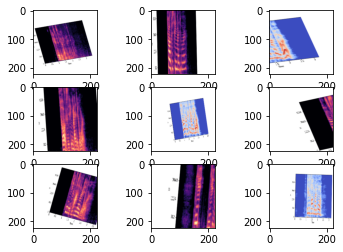

In [125]:
img_rows, img_cols = 224, 224

for x, y in train_datagen.flow(X_train, y_train, batch_size=9):
    # Show the first 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x[i].reshape(img_rows, img_cols, 3))
    # show the plot
    plt.show()
    break

In [126]:
for layer in conv_base.layers[:12]:
    layer.trainable = False

In [127]:
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
22 global_average_pooling2d True


In [128]:
input_shape=(224,224,3)

model=models.Sequential()
model.add(conv_base)
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.01))
model.add(Dense(8,activation='softmax'))
model.summary()

from tensorflow.keras import layers, models, Model, optimizers

#Initializing the hyperparameters
learning_rate = 5e-5
epochs = 80
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics = ['acc'])
history = model.fit(train_generator,
                              epochs = epochs, 
                              # steps_per_epoch = X_train.shape[0]//batch_size, 
                              validation_data = (X_test,y_test), 
                              callbacks=[checkpoint,lr_reduce], 
                              verbose = 1,
                              shuffle=True
                              )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 8)                 2056      
                                                                 
Total params: 20,157,768
Trainable params: 17,832,200
Non-trainable params: 2,325,568
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/80
72/72 [==============================] - ETA: 0s - loss: 1.1882 - acc: 0.5842
Epoch 1: val_acc did not improve from 0.80556
72/72 [==============================] - 28s 365ms/step - loss: 1.1882 - acc: 0.5842 - val_loss: 0.8455 - val_acc: 0.7465 - lr: 5.0000e-05
Epoch 2/80
72/72 [==============================] - ETA: 0s - loss: 0.7292 - acc: 0.7413
Epoch 2: val_acc did not improve from 0.80556
72/72 [==============================] - 26s 360ms/step - loss: 0.7292 - acc: 0.7413 - val_loss: 1.0501 - val_acc: 0.6944 - lr: 5.0000e-05
Epoch 3/80
72/72 [==============================] - ETA: 0s - loss: 0.6955 - acc: 0.7465
Epoch 3: val_acc did not improve from 0.80556
72/72 [==============================] - 26s 363ms/step - loss: 0.6955 - acc: 0.7465 - val_loss: 0.8519 - val_acc: 0.7708 - lr: 5.0000e-05
Epoch 4/80
72/72 [==============================] - ETA: 0s - loss: 0.6537 - acc: 0.7778
Epoch 4: val_acc did not improve from 0.80556
72/72 [==============================] - 24

**Model accuracy graph**

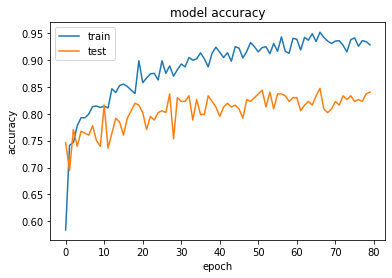

In [129]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Augmented_Model_Accuracy.png')
plt.show()

Model loss graph

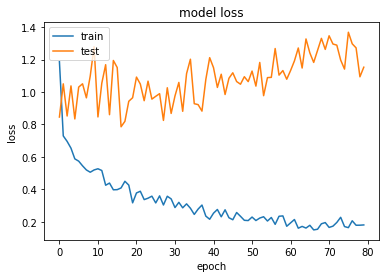

In [130]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Augmented_Model_Loss.png')
plt.show()

**Confusion Matrix**

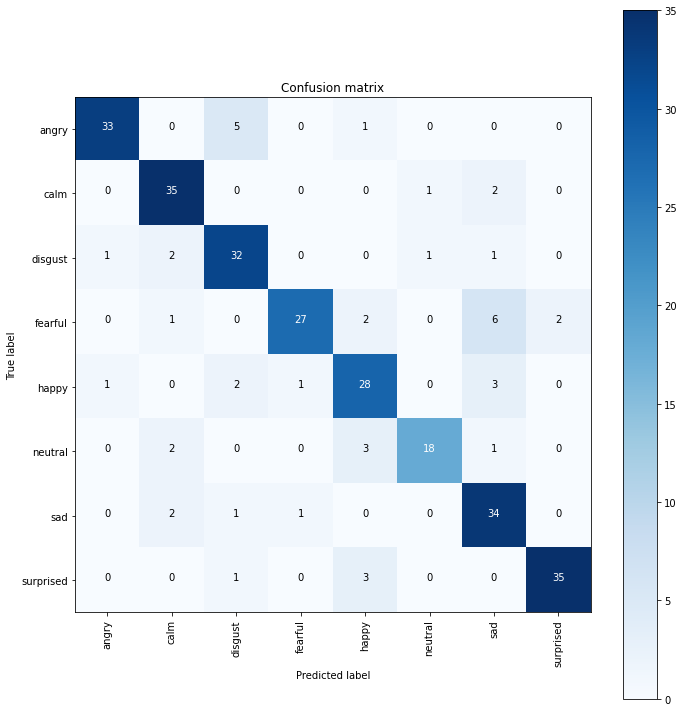

In [131]:
y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_test,axis=1)
dict_characters = {0: 'angry', 1: 'calm', 2: 'disgust', 3: 'fearful', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprised'}
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()

In [132]:
print(classification_report(Y_true, Y_pred_classes, target_names = ['angry','calm','disgust','fearful','happy','neutral','sad','surprised']))

              precision    recall  f1-score   support

       angry       0.94      0.85      0.89        39
        calm       0.83      0.92      0.88        38
     disgust       0.78      0.86      0.82        37
     fearful       0.93      0.71      0.81        38
       happy       0.76      0.80      0.78        35
     neutral       0.90      0.75      0.82        24
         sad       0.72      0.89      0.80        38
   surprised       0.95      0.90      0.92        39

    accuracy                           0.84       288
   macro avg       0.85      0.84      0.84       288
weighted avg       0.85      0.84      0.84       288



In [133]:
tf.keras.models.save_model(model,'//content/drive/MyDrive/SPEECH EMOTION RECOGBITION/vgg_aug.hdf5')

In [134]:
model.save_weights('/content/drive/MyDrive/SPEECH EMOTION RECOGBITION/vgg_aug_weights.h5')

# **CONCLUSION**

So these are the some of the final conclusions after implementing various technique and models in the given dataset.These are as follows:-

1. VGG19 (fine tuning + augmentation) was giving the best accuracy score of 84% and solved the problems like overfitting to some extent.

2. It's quite difficult to get the accuracy of more than 90% due to lack of data.

3. To solve problems like over-fitting that we had seen in almost every model, we need more real-time data.

4. Noise Adding, Pitching and Shifting for the imbalanced data was helping in achieving a better result.

5.Computational cost was much high resulting in several runtime crashes but we’re able to get our best model for deployment.